In [4]:
from enum import IntEnum
from collections import defaultdict
import string
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy
import itertools
import matplotlib.patheffects as path_effects


class TrieMembership(IntEnum):
    invalid = 1
    prefix = 2
    word = 3


SCORE_DICT = defaultdict(lambda: 11, {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 2, 6: 3, 7: 5, 8: 11})

SIZE = 4
MIN_WORD_LEN = 3

_end = '_end_'

'''
Grid starts with (0,0) in the top left corner.
X is column
Y is row
'''

'\nGrid starts with (0,0) in the top left corner.\nX is column\nY is row\n'

In [5]:
def init_grid_figure(input_string):
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='#E6E3DB')

    ax.set_ylim(0, SIZE)
    ax.set_xlim(0, SIZE)
    ax.grid(True, linestyle="-", linewidth=2)

    loc = plt.MultipleLocator(base=1)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)

    plt.gca().set_aspect('equal', adjustable='box')

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    letter_color = "#0495A8"

    for letter, (x, y) in zip(input_string, itertools.product(reversed(range(SIZE)), range(SIZE))):
        ax.annotate(letter,
                    xy=(y + 0.5, x + 0.5),
                    xycoords='data',
                    ha="center",
                    va="center",
                    size=40,
                    color=letter_color,
                    zorder=1)

    line, = ax.plot([],
            [],
            '-',
            color="black",
            linewidth=50,
            zorder=2,
            alpha=0.15,
            solid_capstyle='round')

    plt.show()

    return line


def update_grid_fig(line, word_coords):

    x, y = zip(*list(map(word_coord_to_plot_coord, word_coords)))

    line.set_xdata(x)
    line.set_ydata(y)

    plt.show()
    
    return line


def word_coord_to_plot_coord(coord):
    x, y = coord
    return x + 0.5, SIZE - y - 0.5


In [6]:
def dictionary_gen():
    with open('../../enable1.txt', 'r') as word_list:
        for line in word_list:
            yield line.lower().strip()


def neighbors(x, y):
    # range has to be +1 because range is not inclusive on end
    for nx in range(max(0, x - 1), min(x + 2, SIZE)):
        for ny in range(max(0, y - 1), min(y + 2, SIZE)):
            yield (nx, ny)


def make_trie(words):
    root = dict()
    for word in words:
        current_dict = root
        for letter in word:
            current_dict = current_dict.setdefault(letter, {})
        current_dict[_end] = _end
    return root


def trie_member(trie, word):
    current_dict = trie
    for letter in word:
        try:
            current_dict = current_dict[letter]
        except KeyError:
            return TrieMembership.invalid
    if _end in current_dict:
        return TrieMembership.word
    else:
        return TrieMembership.prefix


def recurse_grid(grid, path, current_word, words_trie, found_words):
    if not path:  # empty path means this is the initial call.
        for y, row in enumerate(grid):
            for x, letter in enumerate(row):
                for (next_path, next_word) in recurse_grid(grid, [(x, y)], letter, words_trie, found_words):
                    yield (next_path, next_word)

        raise StopIteration
    position = path[-1]
    membership = trie_member(words_trie, current_word)
    if membership == TrieMembership.word and current_word not in found_words:
        found_words.add(current_word)
        yield (path, current_word)
    if membership >= TrieMembership.prefix:
        for nx, ny in neighbors(*position):
            if (nx, ny) not in path:
                new_letter = grid[ny][nx]
                new_letter = new_letter if new_letter != 'q' else 'qu'
                new_word = current_word + new_letter
                if trie_member(words_trie, new_word) != TrieMembership.invalid:
                    for (next_path, next_word) in recurse_grid(grid, list(path) + [(nx, ny)], new_word, words_trie, found_words):
                        yield (next_path, next_word)


def generate_word_trie(grid_string):
    grid_string = ''.join(grid_string.lower())
    # grid_string is expected to be a SIZE**2 length string with only letters.

    grid_letters = set(grid_string.replace('q', 'qu'))

    # plausible words are words from the dictionary that only contain
    # letters found in the grid and are more than 3 letters long
    plausible_words = [word for word in dictionary_gen() if len(word) > MIN_WORD_LEN and set(word) <= grid_letters]
    words_trie = make_trie(plausible_words)

    return words_trie


def generate_grid_list(grid_string):
    return [grid_string[i:i + SIZE] for i in range(0, SIZE ** 2, SIZE)]


def total_grid_score(grid_string):
    grid_string = grid_string.lower()

    word_trie = generate_word_trie(grid_string)
    grid = generate_grid_list(grid_string)

    words = set(word for _, word in recurse_grid(grid, list(), "", word_trie, set()))

    return (sum(SCORE_DICT[word_len] for word_len in map(len, words)),)

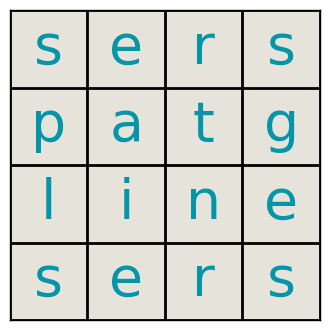

AttributeError: 'Line2D' object has no attribute 'canvas'

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

grid_string = "SERSPATGLINESERS".lower()

grid = generate_grid_list(grid_string)
word_trie = generate_word_trie(grid_string)

line = init_grid_figure(grid_string)

ani = animation.FuncAnimation(line, update_grid_fig, interval=500, blit=True)
HTML(ani.to_html5_video())

In [8]:
def generate_random_boggle_letters():
    return random.choice(string.ascii_lowercase)


def mutate_grid(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = generate_random_boggle_letters()

    return individual,


def simulate():
    toolbox = base.Toolbox()

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Board", list, fitness=creator.FitnessMax)

    toolbox.register("letter", generate_random_boggle_letters)
    toolbox.register("individual", tools.initRepeat, creator.Board, toolbox.letter, n=SIZE ** 2)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", total_grid_score)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutate_grid, indpb=0.25)
    toolbox.register("select", tools.selTournament, tournsize=20)

    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    pop, logbook = algorithms.eaSimple(pop,
                                       toolbox,
                                       cxpb=0.5,
                                       mutpb=0.2,
                                       ngen=10,
                                       stats=stats,
                                       halloffame=hof,
                                       verbose=True)

    return pop, logbook, hof

In [9]:
simulate()

AttributeError: 'Board' object has no attribute 'lower'